# U - Net
## Problem: 

Seismic data is collected using reflection seismology, or seismic reflection. The method requires a controlled seismic source of energy, such as compressed air or a seismic vibrator, and sensors record the reflection from rock interfaces within the subsurface. The recorded data is then processed to create a 3D view of earth’s interior. Reflection seismology is similar to X-ray, sonar and echolocation.

A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. In theory, the strength of reflection is directly proportional to the difference in the physical properties on either sides of the interface. While seismic images show rock boundaries, they don't say much about the rock themselves; some rocks are easy to identify while some are difficult.

There are several areas of the world where there are vast quantities of salt in the subsurface. One of the challenges of seismic imaging is to identify the part of subsurface which is salt. Salt has characteristics that makes it both simple and hard to identify. Salt density is usually 2.14 g/cc which is lower than most surrounding rocks. The seismic velocity of salt is 4.5 km/sec, which is usually faster than its surrounding rocks. This difference creates a sharp reflection at the salt-sediment interface. Usually salt is an amorphous rock without much internal structure. This means that there is typically not much reflectivity inside the salt, unless there are sediments trapped inside it. The unusually high seismic velocity of salt can create problems with seismic imaging.

### Data
The data is a set of images chosen at various locations chosen at random in the subsurface. The images are 101 x 101 pixels and each pixel is classified as either salt or sediment. In addition to the seismic images, the depth of the imaged location is provided for each image. The goal of the competition is to segment regions that contain salt.

#### Source: 
https://www.kaggle.com/c/tgs-salt-identification-challenge


### Note: 
Accept the terms and download data from the above link

### Aim: 

Implement U-Net neural model architecture in keras to solve this problem.


In this, you are asked to segment salt deposits beneath the Earth’s surface. Given a set of seismic images that are 101 x 101 pixels each and each pixel we need to classify as either salt or sediment. Our goal is to segment regions that contain salt. A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. 

### Broad Steps:

1. Download the dataset
2. Upload to Drive
3. Import from drive to colab
4. Load the images and create training data.
5. Build U-net Model
6. Train your model.
7. Check the validation accuracy and plot sample.

In [1]:
#Importing necessary libraries
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


### 1.Set your project path where you have your data and related files for this lab.

In [0]:
os.chdir('/content/drive/My Drive/Resedency9')
project_path = '/content/drive/My Drive/Resedency9/'

### 2. Set the necessary parameters

## Setup

In [0]:
im_width = 128      #width of your train image
im_height = 128     #hight of your train image
#border =        
path_train = project_path + 'train/'   #Path for your train data

In [28]:
print(path_train)

/content/drive/My Drive/Resedency9/train/


# 3. Make directory for train data at in your project/lab folder.

Hint - use !mkdir function.

In [0]:
try:
    os.mkdir(path_train)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

# 4. Extract your train images to the train directory you have just created above. 
train.zip and test.zip files available at your google drive/local system.

As a good practice - Upload or copy the data at your project path folder.

Make sure you are providing the right project_path.

In [29]:
print(project_path)

/content/drive/My Drive/Resedency9/


In [0]:
#For simplicity we have added the required code here.
from zipfile import ZipFile

with ZipFile(project_path + 'train.zip', 'r') as zf:
  zf.extractall('train/')


In [0]:
#The train file have both images and masks with the same names_ids.

### 5. Get the list of names of images and masks and name the list imagelist and masklist.

Hint - Use os.listdir() funtions.

In [30]:
os.listdir(project_path)

['data',
 'data.zip',
 'train.zip',
 'train (1)',
 'R9_External_Lab_Questions.ipynb']

In [0]:
imagelist  = os.listdir(project_path+'train (1)/images')
masklist = os.listdir(project_path+'train (1)/masks')

In [32]:
#Test your list names by printing some of the names as given below.
print(imagelist[-1])
print(masklist[-1])
print(imagelist[10])
print(masklist[10])

429bf7c665.png
423ae1a09c.png
bfc47bbe13.png
c092a99d23.png


# 6. Read and test your images and respective masks.

Hint -

import  matplotlib.pyplot as plt

import cv2

plt.imshow(cv2.imread('path of image'))

plt.imshow(cv2.imread('path of mask'))


In [0]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image

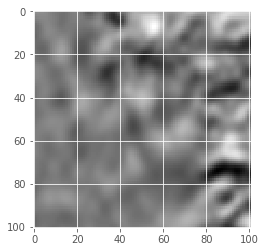

In [37]:

for file in imagelist:
   n = imagelist.index(file)
   path1 = os.path.join(project_path+'train (1)/images',file)
   plt.imshow(cv2.imread(path1))
   break 

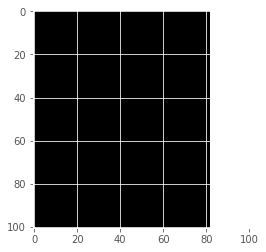

In [38]:
for file in masklist:
   n = masklist.index(file)
   path2 = os.path.join(project_path+'train (1)/masks',file)
   plt.imshow(cv2.imread(path2))
   break

# 7. Create your training data.

Hints - 

image_path = os.path.join(project_path +'path of your image directory' +n )

mask_path = os.path.join(project_path +'path of your mask directory'+n )

In [0]:
# Get and resize train images and masks
def get_data():
    X = np.zeros(((len(imagelist), im_height, im_width, 1)), dtype=np.float32) # Create an array for image
    y = np.zeros(((len(masklist), im_height, im_width, 1)), dtype=np.float32) #Create an array for mask
    
    for n in imagelist: 
        k = imagelist.index(n)
        ##Add image_path
        image_path = os.path.join(project_path+'train (1)/images', n)
        ##Add mask_path
        mask_path = os.path.join(project_path+'train (1)/masks', n)                                                           
        
        # Load images and resize to (128,128,1)
        resized_img = Image.open(image_path)
        resized_img = resized_img.resize((im_width, im_height))
        resized_img = np.reshape(resized_img.convert('L'), (128,128,1)) ## Converting the image to greyscale # Minimizing the parameters
        # Load masks and resize to (128,128,1)
        resized_mask = Image.open(mask_path)
        resized_mask = resized_mask.resize((im_width, im_height))
        resized_mask = np.reshape(resized_mask.convert('L'), (128,128,1)) ## Converting the image to greyscale # Minimizing the parameters
        # Save images
        X[k] = resized_img /255
        y[k] = resized_mask/255
    print('Done!')
    return X, y
    
X, y = get_data()

Done!


In [0]:
X.shape

(4000, 128, 128, 1)

In [0]:
y.shape

(4000, 128, 128, 1)

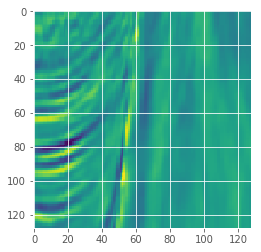

In [0]:
plt.imshow(X[1].squeeze())

# Not Done the Below CNN execution as the Unet Segmentation topics are still not covered

In [0]:
# Split train and valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2019)

In [0]:
## Test your data whether it looks fine - Random check
import random 
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');




### 8. Define loss and dice_coeff function.

### 9. Build and compile UNet Model for your data.

Hint - 
You can install and use segmentation models from this github repository.

#Install segmentation models

!pip install git+https://github.com/qubvel/segmentation_models

In [0]:
#model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(None, None, 1))
#compile your model by adding the parameters like optimizer, loss and metrics.



In [0]:
#Get the summary of your model


### 10. Fit your model using model.fit function.
Hint - As it might take long time to run. Run it for only 1 or 2 epochs.

### 11.Predict on val set using model.predict funtion and store in preds_val variable.



In [0]:
#Get the threshold predictions to look at refined results.
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [0]:
#Plot a sample
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

In [0]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=15)

If you are getting good results- Congratulations.
If you are not, try to explore what might be the reason.

# Text generation using a RNN

Given a sequence of words from this data, train a model to predict the next word in the sequence. Longer sequences of text can be generated by calling the model repeatedly.

**Mount your Google Drive**

In [2]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os
os.chdir('/content/drive/My Drive/Resedency9/data')

### Import Keras and other libraries

In [4]:
import glob

from sklearn.utils import shuffle
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam
from keras import backend

Using TensorFlow backend.


## Download data
Reference: Data is collected from http://www.gutenberg.org

For the lab purpose, you can load the dataset provided by Great Learning

### Load the Oscar Wilde dataset

Store all the ".txt" file names in a list

In [5]:
oscarWildelist = glob.glob("*.txt")
print(oscarWildelist)

['A Critic in Pall Mall.txt', 'A House of Pomegranates.txt', 'A Woman of No Importance a play.txt', 'Children in Prison and Other Cruelties of Prison Life.txt', 'An Ideal Husband.txt', 'De Profundis.txt', 'Charmides and Other Poems.txt', 'For Love of the King.txt', 'Essays and Lectures.txt', 'Impressions of America.txt', 'Intentions.txt', 'Lady Windermere_s Fan.txt', 'Lord Arthur Savile_s Crime.txt', 'Selected poems of oscar wilde including The Ballad of Reading Gaol.txt', 'Rose Leaf and Apple Leaf.txt', 'Poems with the Ballad of Reading Gaol.txt', 'Oscar Wilde Miscellaneous.txt', 'Salomé A tragedy in one act.txt', 'Miscellaneous Aphorisms_ The Soul of Man.txt', 'Selected prose of oscar wilde with a Preface by Robert Ross.txt', 'Reviews.txt', 'Miscellanies.txt', 'Shorter Prose Pieces.txt', 'The Ballad of Reading Gaol.txt', 'The Duchess of Padua.txt', 'The Canterville Ghost.txt', 'The Happy Prince and other tales.txt', 'The Picture of Dorian Gray.txt', 'The Importance of Being Earnest.

### Read the data

Read contents of every file from the list and append the text in a new list

In [0]:
codetext = []
bookranges = []
for oscarWildefile in oscarWildelist:
  oscartext = open(oscarWildefile, "r")
  start = len(codetext)
  codetext.append(oscartext.read())
  end = len(codetext)
  bookranges.append({"start": start, "end": end, "name": oscarWildefile.rsplit("/", 1)[-1]})
  oscartext.close()

## Process the text
Initialize and fit the tokenizer

In [0]:
tokenizer = Tokenizer(lower=True, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(codetext)

### Vectorize the text

Before training, we need to map strings to a numerical representation. Create two lookup tables: one mapping words to numbers, and another for numbers to words.

In [0]:
word_idx = tokenizer.word_index
idx_word = tokenizer.index_word

Get the word count for every word and also get the total number of words.

In [0]:
word_counts = tokenizer.word_counts
num_words = len(word_idx) + 1

Convert text to sequence of numbers

In [0]:
sequences = tokenizer.texts_to_sequences(codetext)

### Generate Features and Labels

In [0]:
features = []
labels = []

training_length = 50
# Iterate through the sequences of tokens
for seq in sequences:
    # Create multiple training examples from each sequence
    for i in range(training_length, training_length+300):
        # Extract the features and label
        extract = seq[i - training_length: i - training_length + 20]

        # Set the features and label
        features.append(extract[:-1])
        labels.append(extract[-1])

### The prediction task

Given a word, or a sequence of words, what is the most probable next word? This is the task we're training the model to perform. The input to the model will be a sequence of words, and we train the model to predict the output—the following word at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the words computed until this moment, what is the next word?

### Generate training and testing data

In [0]:
from sklearn.utils import shuffle
import numpy as np

features, labels = shuffle(features, labels, random_state=1)

# Decide on number of samples for training
train_end = int(0.7 * len(labels))

train_features = np.array(features[:train_end])
valid_features = np.array(features[train_end:])

train_labels = labels[:train_end]
valid_labels = labels[train_end:]

# Convert to arrays
X_train, X_valid = np.array(train_features), np.array(valid_features)

# Using int8 for memory savings
y_train = np.zeros((len(train_labels), num_words), dtype=np.int8)
y_valid = np.zeros((len(valid_labels), num_words), dtype=np.int8)

# One hot encoding of labels
for example_index, word_index in enumerate(train_labels):
    y_train[example_index, word_index] = 1

for example_index, word_index in enumerate(valid_labels):
    y_valid[example_index, word_index] = 1

This is just to check the features and labels

In [13]:
for i, sequence in enumerate(X_train[:2]):
    text = []
#     print(i, sequence)
    for idx in sequence:
        text.append(idx_word[idx])
        
    print('Features: ' + ' '.join(text)+'\n')
    print('Label: ' + idx_word[np.argmax(y_train[i])] + '\n')

Features: down on him making satirical remarks on the photographs suddenly there leaped out two figures 'poor poor ghost '

Label: she

Features: and other poems author oscar wilde release date september 19 2014 ebook 1031 this file was first posted on

Label: 17



## Build The Model

Use `keras.Sequential` to define the model. For this simple example three layers are used to define our model:

* `keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
* `keras.layers.LSTM`: A type of RNN with size `units=rnn_units` (You can also use a GRU layer here.)
* `keras.layers.Dense`: The output layer, with `num_words` outputs.

In [14]:
model = Sequential()

# Embedding layer
model.add(
    Embedding(
        input_dim=len(word_idx) + 1,
        output_dim=100,
        weights=None,
        trainable=True))

# Recurrent layer
model.add(
    LSTM(
        64, return_sequences=False, dropout=0.1,
        recurrent_dropout=0.1))

# Fully connected layer
model.add(Dense(64, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_words, activation='softmax'))

# Compile the model
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

W0721 14:05:30.629365 139995219507072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0721 14:05:30.668369 139995219507072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0721 14:05:30.674100 139995219507072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0721 14:05:30.791287 139995219507072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0721 14:05:30.804279 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         3283900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32839)             2134535   
Total params: 5,464,835
Trainable params: 5,464,835
Non-trainable params: 0
_________________________________________________________________


For each word the model looks up the embedding, runs the LSTM one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-liklihood of the next word.

## Train the model

In [15]:
h = model.fit(X_train, y_train, epochs = 500, batch_size = 50, 
          verbose = 1)## Train the model

W0721 14:05:40.092331 139995219507072 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/500
6510/6510 [==============================] - 10s 2ms/step - loss: 8.2992 - acc: 0.0581
Epoch 2/500
6510/6510 [==============================] - 5s 796us/step - loss: 6.7376 - acc: 0.0614
Epoch 3/500
6510/6510 [==============================] - 5s 797us/step - loss: 6.4581 - acc: 0.0584
Epoch 4/500
6510/6510 [==============================] - 5s 798us/step - loss: 6.2733 - acc: 0.0594
Epoch 5/500
6510/6510 [==============================] - 5s 795us/step - loss: 6.1360 - acc: 0.0625
Epoch 6/500
6510/6510 [==============================] - 5s 791us/step - loss: 5.9883 - acc: 0.0630
Epoch 7/500
6510/6510 [==============================] - 5s 797us/step - loss: 5.8559 - acc: 0.0668
Epoch 8/500
6510/6510 [==============================] - 5s 794us/step - loss: 5.7357 - acc: 0.0705
Epoch 9/500
6510/6510 [==============================] - 5s 786us/step - loss: 5.6345 - acc: 0.0757
Epoch 10/500
6510/6510 [==============================] - 5s 781us/step - loss: 5.5578 - acc: 0.0782


### Save Model

In [0]:
# save the model to file
model.save('.SemiTrainedModel_500epochs.h5')

## If you have already trained the model and saved it, you can load a pretrained model

In [0]:
# load the model
model = load_model('.SemiTrainedModel_500epochs.h5')

### Note: After loading the model run  model.fit()  to continue training form there, if required.

In [18]:
model.fit(X_train, y_train, batch_size=50, epochs=500)

Epoch 1/500
6510/6510 [==============================] - 6s 919us/step - loss: 0.2926 - acc: 0.9092
Epoch 2/500
6510/6510 [==============================] - 5s 799us/step - loss: 0.3189 - acc: 0.8962
Epoch 3/500
6510/6510 [==============================] - 5s 806us/step - loss: 0.3186 - acc: 0.9000
Epoch 4/500
6510/6510 [==============================] - 5s 795us/step - loss: 0.3340 - acc: 0.8985
Epoch 5/500
6510/6510 [==============================] - 5s 797us/step - loss: 0.3042 - acc: 0.9048
Epoch 6/500
6510/6510 [==============================] - 5s 798us/step - loss: 0.3156 - acc: 0.9025
Epoch 7/500
6510/6510 [==============================] - 5s 800us/step - loss: 0.3173 - acc: 0.9031
Epoch 8/500
6510/6510 [==============================] - 5s 801us/step - loss: 0.3294 - acc: 0.8971
Epoch 9/500
6510/6510 [==============================] - 5s 812us/step - loss: 0.3341 - acc: 0.8994
Epoch 10/500
6510/6510 [==============================] - 5s 799us/step - loss: 0.3233 - acc: 0.8998

## Evaluation

In [19]:
print(model.evaluate(X_train, y_train, batch_size = 20))
print('\nModel Performance: Log Loss and Accuracy on validation data')
print(model.evaluate(X_valid, y_valid, batch_size = 20))

6510/6510 [==============================] - 4s 615us/step
[0.02733311530364629, 0.993855605293895]

Model Performance: Log Loss and Accuracy on validation data
2790/2790 [==============================] - 2s 550us/step
[9.317935273638764, 0.3720430124511001]


## Generate text

In [32]:
seed_length=50
new_words=50
diversity=1
n_gen=1

import random

# Choose a random sequence
seq = random.choice(sequences)

# print seq

# Choose a random starting point
seed_idx = random.randint(0, len(seq) - seed_length - 10)
# Ending index for seed
end_idx = seed_idx + seed_length

gen_list = []

for n in range(n_gen):
    # Extract the seed sequence
    seed = seq[seed_idx:end_idx]
    original_sequence = [idx_word[i] for i in seed]
    generated = seed[:] + ['#']

    # Find the actual entire sequence
    actual = generated[:] + seq[end_idx:end_idx + new_words]
        
    # Keep adding new words
    for i in range(new_words):

        # Make a prediction from the seed
        preds = model.predict(np.array(seed).reshape(1, -1))[0].astype(np.float64)

        # Diversify
        preds = np.log(preds) / diversity
        exp_preds = np.exp(preds)

        # Softmax
        preds = exp_preds / sum(exp_preds)

        # Choose the next word
        probas = np.random.multinomial(1, preds, 1)[0]

        next_idx = np.argmax(probas)

        # New seed adds on old word
        #             seed = seed[1:] + [next_idx]
        seed += [next_idx]
        generated.append(next_idx)
    # Showing generated and actual abstract
    n = []

    for i in generated:
        n.append(idx_word.get(i, '< --- >'))

    gen_list.append(n)

a = []

for i in actual:
    a.append(idx_word.get(i, '< --- >'))

a = a[seed_length:]

gen_list = [gen[seed_length:seed_length + len(a)] for gen in gen_list]

print('Original Sequence: \n'+' '.join(original_sequence))
print("\n")
# print(gen_list)
print('Generated Sequence: \n'+' '.join(gen_list[0][1:]))
# print(a)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


Original Sequence: 
left me as she came unwarned and fell from sighing into sleep before the summer morning dawned what wonder now i find no maiden fair who dwells between these mountains and the seas and go unloving and unloved or ere i turn to such as these what wonder if the


Generated Sequence: 
day is in the sting of beauty in archaeology herod suppliant the tetrarch's remorse the tetrarch's treasure salome rose 25 lady and a cappadocian by seeing crowned again with paltry mrs an was has new background without frontiers the poetry of archaeology herod suppliant the tetrarch's remorse the tetrarch's treasure
